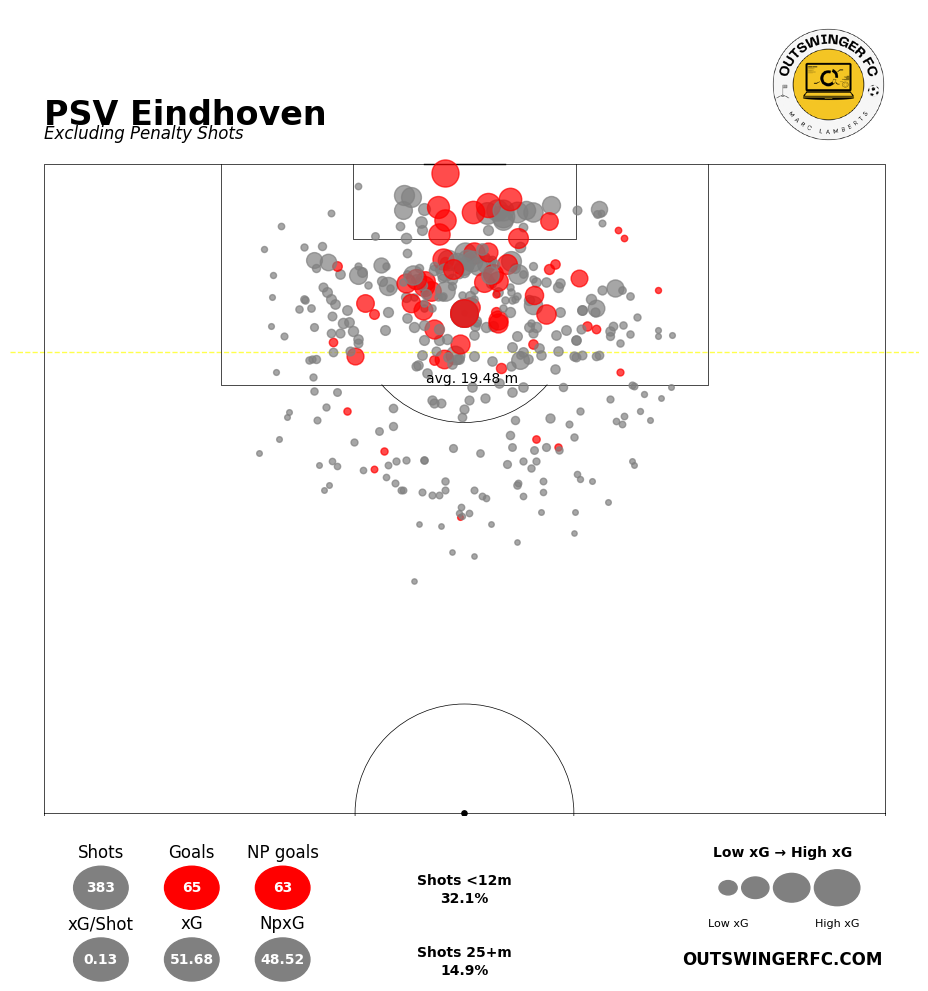

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Circle

# Load the Excel file
file_path = r'/Users/marclambertes/Python/Eredivisie psxg.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Filter for the specific team (e.g., PSV)
df = df.loc[df['TeamId'] == 'PSV Eindhoven'].reset_index()

# Ensure the DataFrame is not empty
if df.empty:
    print("No data available for the selected team or conditions.")
    exit()

# Calculate summary statistics
total_shots = df.shape[0]
if total_shots == 0:
    print("No shots available for calculations.")
    exit()

non_penalty_goals = df[(df['Type_of_play'] != 'Penalty') & (df['isGoal'] == 1)].shape[0]  # NPG
total_goals = df['isGoal'].sum()
total_xG = df['xG'].sum()
total_xG_from_penalties = df[df['Type_of_play'] == 'Penalty']['xG'].sum()
total_xG_minus_penalties = total_xG - total_xG_from_penalties
xG_per_shot = total_xG / total_shots
avg_distance = 105 - df['x'].mean()  # Assuming a standard pitch length of 105 meters

# Create the pitch
pitch = VerticalPitch(pitch_type='opta', pitch_color='white', line_color='black', half=False, line_zorder=2, linewidth=0.5)
fig, ax = pitch.draw(figsize=(14, 10))  # Larger figure size

# Adjust y-axis to cut at 50 (top of the plot is at y=50)
ax.set_ylim(49.8, 105)  # Display only the area from x=50 to x=105

# Plot the shots
for x in range(len(df['x'])):
    color = 'red' if df['isGoal'][x] else 'grey'
    size = df['xG'][x] * 500
    plt.scatter(df['y'][x], df['x'][x], color=color, s=size, alpha=.7, zorder=3)

# Add average shot distance line
avg_y = df['x'].mean()
avg_x = df['y'].mean()
plt.axhline(y=avg_y, color='yellow', linestyle='dashed', linewidth=1, alpha=0.7, zorder=1)
plt.text(avg_x + 5, avg_y - 2, f'avg. {avg_distance:.2f} m', fontsize=10, color='black', ha='left', va='center')

# Add left top corner title
player_name = "PSV Eindhoven"  # Replace with the actual player name
title_text = f"{player_name}"
subtitle_text = "Excluding Penalty Shots"

# Add the title
ax.text(100, 105, title_text, fontsize=24, weight='bold', color='black', ha='left', va='top')

# Add the subtitle in italics
ax.text(100, 103, subtitle_text, fontsize=12, style='italic', color='black', ha='left', va='top')

# Add logo to the top-right corner
logo_path = r'Outswinger FC (3).png'  # Replace with the path to your logo file
logo_img = plt.imread(logo_path)
imagebox = OffsetImage(logo_img, zoom=0.5)
ab = AnnotationBbox(imagebox, (0.9, 1.02), frameon=False, xycoords='axes fraction', box_alignment=(0.5, 0.5))
ax.add_artist(ab)

# Calculate percentages for shots <12 meters and 25+ meters from the goal line
shots_less_12m = (df[df['distance'] <= 12].shape[0] / total_shots) * 100  # Shots <12 meters
shots_more_25m = (df[df['distance'] >= 25].shape[0] / total_shots) * 100  # Shots 25+ meters

# Adjust the plot to add extra space below the pitch
plt.subplots_adjust(bottom=0.35)  # Add extra margin for the new boxes

# Define positions, labels, values, and colors for the circles
circle_positions = [(0.1, -0.10), (0.1, -0.2), (0.2, -0.10), (0.2, -0.2), (0.3, -0.1), (0.3, -0.2)]
circle_texts = ["Shots", "xG/Shot", "Goals", "xG", "NP goals", "NpxG"]
values = [
    total_shots,
    round(xG_per_shot, 2),
    total_goals,
    round(total_xG, 2),
    non_penalty_goals,
    round(total_xG_minus_penalties, 2)
]
circle_colors = ["grey", "grey", "red", "grey", "red", "grey"]

# Plot circles with text above and values inside
for pos, text, value, color in zip(circle_positions, circle_texts, values, circle_colors):
    circle = Circle(pos, 0.03, transform=ax.transAxes, color=color, zorder=5, clip_on=False)
    ax.add_artist(circle)
    ax.text(pos[0], pos[1] + 0.05, text, transform=ax.transAxes, color='black', fontsize=12,
            ha='center', va='center', zorder=6)
    ax.text(pos[0], pos[1], value, transform=ax.transAxes, color='white', fontsize=10,
            weight='bold', ha='center', va='center', zorder=6)

# Define positions for the boxes and their content
box_positions = [(0.5, -0.10), (0.5, -0.2)]
box_texts = ["Shots <12m", "Shots 25+m"]
box_values = [f"{shots_less_12m:.1f}%", f"{shots_more_25m:.1f}%"]

# Plot white boxes with black text
for pos, text, value in zip(box_positions, box_texts, box_values):
    ax.add_patch(plt.Rectangle(
        (pos[0] - 0.05, pos[1] - 0.03), 0.1, 0.06, transform=ax.transAxes,
        color='white', zorder=5, clip_on=False, edgecolor='black', linewidth=1
    ))
    ax.text(pos[0], pos[1] + 0.01, text, transform=ax.transAxes, color='black', fontsize=10,
            weight='bold', ha='center', va='center', zorder=6)
    ax.text(pos[0], pos[1] - 0.015, value, transform=ax.transAxes, color='black', fontsize=10,
            weight='bold', ha='center', va='center', zorder=6)

# Adjust the plot to add space for the xG size visualization
plt.subplots_adjust(bottom=0.25, right=0.85)

# Define positions for circles (xG sizes) and their corresponding labels
circle_sizes = [0.01, 0.015, 0.02, 0.025]
circle_labels = ["Low xG", "", "", "High xG"]
circle_positions = [(0.79, -0.1), (0.82, -0.1), (0.86, -0.1), (0.91, -0.1)]

# Plot circles and labels
for radius, label, position in zip(circle_sizes, circle_labels, circle_positions):
    circle = plt.Circle(position, radius=radius, transform=ax.transAxes,
                        color='grey', alpha=1, zorder=5, clip_on=False)
    ax.add_artist(circle)
    if label:
        ax.text(position[0], position[1] - 0.05, label, transform=ax.transAxes, fontsize=8,
                color='black', ha='center', va='center')

# Add "Low xG → High xG" label for better context
ax.text(0.85, -0.05, "Low xG → High xG", transform=ax.transAxes, fontsize=10,
        color='black', ha='center', va='center', weight='bold')

# Add bold text in caps: OUTSWINGERFC.COM
ax.text(0.85, -0.2, "OUTSWINGERFC.COM", transform=ax.transAxes, fontsize=12,
        color='black', ha='center', va='center', weight='bold')

# Save and display the plot
plt.savefig('shotmap_with_circles_indicator.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


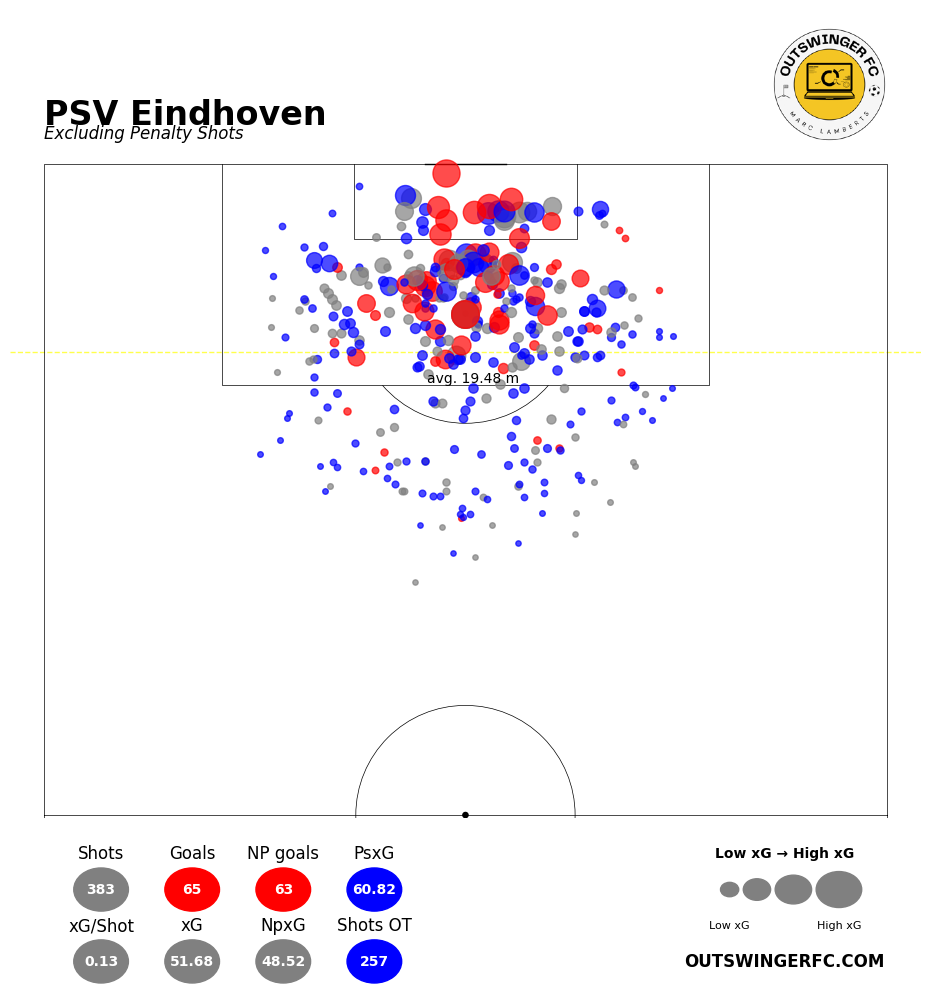

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Circle

# Load the Excel file
file_path = r'/Users/marclambertes/Python/Eredivisie psxg.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Filter for the specific team (e.g., PSV Eindhoven)
df = df.loc[df['TeamId'] == 'PSV Eindhoven'].reset_index()

# Ensure the DataFrame is not empty
if df.empty:
    print("No data available for the selected team or conditions.")
    exit()

# Calculate summary statistics
total_shots = df.shape[0]
if total_shots == 0:
    print("No shots available for calculations.")
    exit()

non_penalty_goals = df[(df['Type_of_play'] != 'Penalty') & (df['isGoal'] == 1)].shape[0]
total_goals = df['isGoal'].sum()
total_xG = df['xG'].sum()
total_xG_from_penalties = df[df['Type_of_play'] == 'Penalty']['xG'].sum()
total_xG_minus_penalties = total_xG - total_xG_from_penalties
xG_per_shot = total_xG / total_shots
avg_distance = 105 - df['x'].mean()  # Assuming a standard pitch length of 105 meters

# Additional calculations for PsxG and Shots on Target
total_psxg = df['PsxG'].sum() if 'PsxG' in df.columns else 0
shots_on_target = df[df['Shot_on_Target'] == True].shape[0]

# Create the pitch
pitch = VerticalPitch(pitch_type='opta', pitch_color='white', line_color='black', half=False, line_zorder=2, linewidth=0.5)
fig, ax = pitch.draw(figsize=(14, 10))

# Adjust y-axis to cut at 50
ax.set_ylim(49.8, 105)

# Plot the shots
# Plot the shots
for i in range(len(df['x'])):
    if df['isGoal'][i]:  # If it's a goal
        color = 'red'  # Red for all goals
    elif df['Shot_on_Target'][i]:  # If it's on target but not a goal
        color = 'blue'  # Blue for shots on target
    else:
        color = 'grey'  # Grey for other shots
    size = df['xG'][i] * 500
    plt.scatter(df['y'][i], df['x'][i], color=color, s=size, alpha=0.7, zorder=3)

# Add average shot distance line
avg_y = df['x'].mean()
avg_x = df['y'].mean()
plt.axhline(y=avg_y, color='yellow', linestyle='dashed', linewidth=1, alpha=0.7, zorder=1)
plt.text(avg_x + 5, avg_y - 2, f'avg. {avg_distance:.2f} m', fontsize=10, color='black', ha='left', va='center')

# Add title and subtitle
player_name = "PSV Eindhoven"
title_text = f"{player_name}"
subtitle_text = "Excluding Penalty Shots"
ax.text(100, 105, title_text, fontsize=24, weight='bold', color='black', ha='left', va='top')
ax.text(100, 103, subtitle_text, fontsize=12, style='italic', color='black', ha='left', va='top')

# Add logo
logo_path = r'Outswinger FC (3).png'
logo_img = plt.imread(logo_path)
imagebox = OffsetImage(logo_img, zoom=0.5)
ab = AnnotationBbox(imagebox, (0.9, 1.02), frameon=False, xycoords='axes fraction', box_alignment=(0.5, 0.5))
ax.add_artist(ab)

# Calculate percentages for shots <12 meters and 25+ meters
shots_less_12m = (df[df['distance'] <= 12].shape[0] / total_shots) * 100
shots_more_25m = (df[df['distance'] >= 25].shape[0] / total_shots) * 100

# Adjust plot for additional space
plt.subplots_adjust(bottom=0.35)

# Define positions, labels, values, and colors for the circles
circle_positions = [
    (0.1, -0.10), (0.1, -0.2), (0.2, -0.10), (0.2, -0.2),
    (0.3, -0.1), (0.3, -0.2), (0.4, -0.10), (0.4, -0.2)
]
circle_texts = ["Shots", "xG/Shot", "Goals", "xG", "NP goals", "NpxG", "PsxG", "Shots OT"]
values = [
    total_shots,
    round(xG_per_shot, 2),
    total_goals,
    round(total_xG, 2),
    non_penalty_goals,
    round(total_xG_minus_penalties, 2),
    round(total_psxg, 2),
    shots_on_target
]
circle_colors = ["grey", "grey", "red", "grey", "red", "grey", "blue", "blue"]

# Plot circles with text above and values inside
for pos, text, value, color in zip(circle_positions, circle_texts, values, circle_colors):
    circle = Circle(pos, 0.03, transform=ax.transAxes, color=color, zorder=5, clip_on=False)
    ax.add_artist(circle)
    ax.text(pos[0], pos[1] + 0.05, text, transform=ax.transAxes, color='black', fontsize=12,
            ha='center', va='center', zorder=6)
    ax.text(pos[0], pos[1], value, transform=ax.transAxes, color='white', fontsize=10,
            weight='bold', ha='center', va='center', zorder=6)

# Add xG size indicator
circle_sizes = [0.01, 0.015, 0.02, 0.025]
circle_labels = ["Low xG", "", "", "High xG"]
circle_positions = [(0.79, -0.1), (0.82, -0.1), (0.86, -0.1), (0.91, -0.1)]

for radius, label, position in zip(circle_sizes, circle_labels, circle_positions):
    circle = plt.Circle(position, radius=radius, transform=ax.transAxes,
                        color='grey', alpha=1, zorder=5, clip_on=False)
    ax.add_artist(circle)
    if label:
        ax.text(position[0], position[1] - 0.05, label, transform=ax.transAxes, fontsize=8,
                color='black', ha='center', va='center')

ax.text(0.85, -0.05, "Low xG → High xG", transform=ax.transAxes, fontsize=10,
        color='black', ha='center', va='center', weight='bold')

ax.text(0.85, -0.2, "OUTSWINGERFC.COM", transform=ax.transAxes, fontsize=12,
        color='black', ha='center', va='center', weight='bold')

# Save and display the plot
plt.savefig('shotmap_with_psxg_and_shots_ot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


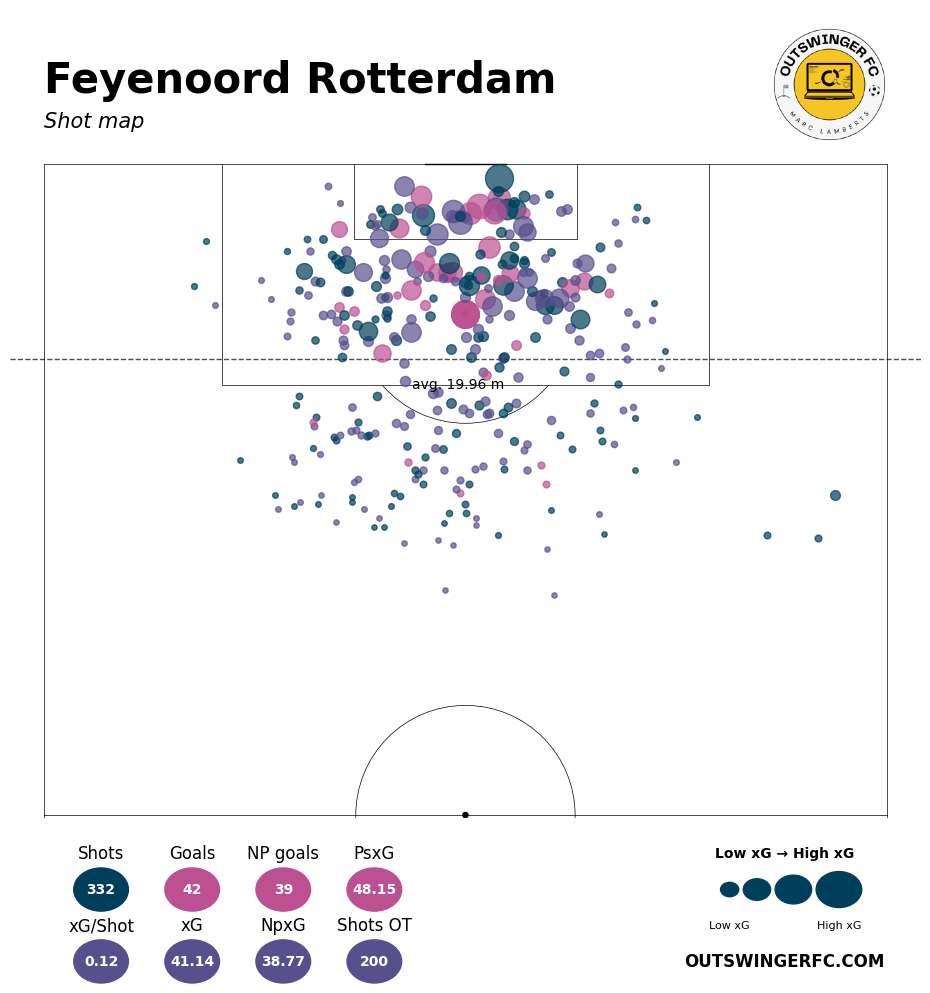

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Circle
from matplotlib.patches import Arc


# Load the Excel file
file_path = r'/Users/marclambertes/Python/Eredivisie psxg.xlsx'  # Replace with your actual file path
df = pd.read_excel(file_path)

# Filter for the specific team (e.g., PSV Eindhoven)
df = df.loc[df['TeamId'] == 'Feyenoord Rotterdam'].reset_index()

# Ensure the DataFrame is not empty
if df.empty:
    print("No data available for the selected team or conditions.")
    exit()

# Calculate summary statistics
total_shots = df.shape[0]
if total_shots == 0:
    print("No shots available for calculations.")
    exit()

non_penalty_goals = df[(df['Type_of_play'] != 'Penalty') & (df['isGoal'] == 1)].shape[0]
total_goals = df['isGoal'].sum()
total_xG = df['xG'].sum()
total_xG_from_penalties = df[df['Type_of_play'] == 'Penalty']['xG'].sum()
total_xG_minus_penalties = total_xG - total_xG_from_penalties
xG_per_shot = total_xG / total_shots
avg_distance = 105 - df['x'].mean()  # Assuming a standard pitch length of 105 meters

# Additional calculations for PsxG and Shots on Target
total_psxg = df['PsxG'].sum() if 'PsxG' in df.columns else 0
shots_on_target = df[df['Shot_on_Target'] == True].shape[0]

# Define colors
colors = {
    "missed": "#003f5c",  # Grey equivalent
    "on_target": "#58508d",  # Blue equivalent
    "goal": "#bc5090",  # Red equivalent
}

# Create the pitch
pitch = VerticalPitch(pitch_type='opta', pitch_color='white', line_color='black', half=False, line_zorder=2, linewidth=0.5)
fig, ax = pitch.draw(figsize=(14, 10))

# Adjust y-axis to cut at 50
ax.set_ylim(49.8, 105)

# Plot the shots
for i in range(len(df['x'])):
    if df['isGoal'][i]:  # Prioritize red for goals
        color = colors["goal"]
    elif df['Shot_on_Target'][i]:  # Blue for on-target shots that are not goals
        color = colors["on_target"]
    else:  # Grey for all other shots
        color = colors["missed"]
    size = df['xG'][i] * 500
    plt.scatter(df['y'][i], df['x'][i], color=color, s=size, alpha=0.7, zorder=3)

# Add average shot distance line
avg_y = df['x'].mean()
avg_x = df['y'].mean()
plt.axhline(y=avg_y, color='black', linestyle='dashed', linewidth=1, alpha=0.7, zorder=1)
plt.text(avg_x + 5, avg_y - 2, f'avg. {avg_distance:.2f} m', fontsize=10, color='black', ha='left', va='center')

# Add title and subtitle
player_name = "Feyenoord Rotterdam"
title_text = f"{player_name}"
subtitle_text = "Shot map"
ax.text(100, 108, title_text, fontsize=30, weight='bold', color='black', ha='left', va='top')
ax.text(100, 104, subtitle_text, fontsize=15, style='italic', color='black', ha='left', va='top')

# Add logo
logo_path = r'Outswinger FC (3).png'
logo_img = plt.imread(logo_path)
imagebox = OffsetImage(logo_img, zoom=0.5)
ab = AnnotationBbox(imagebox, (0.9, 1.02), frameon=False, xycoords='axes fraction', box_alignment=(0.5, 0.5))
ax.add_artist(ab)

# Calculate percentages for shots <12 meters and 25+ meters
shots_less_12m = (df[df['distance'] <= 12].shape[0] / total_shots) * 100
shots_more_25m = (df[df['distance'] >= 25].shape[0] / total_shots) * 100

# Adjust plot for additional space
plt.subplots_adjust(bottom=0.35)

# Define positions, labels, values, and colors for the circles
circle_positions = [
    (0.1, -0.10), (0.1, -0.2), (0.2, -0.10), (0.2, -0.2),
    (0.3, -0.1), (0.3, -0.2), (0.4, -0.10), (0.4, -0.2)
]
circle_texts = ["Shots", "xG/Shot", "Goals", "xG", "NP goals", "NpxG", "PsxG", "Shots OT"]
values = [
    total_shots,
    round(xG_per_shot, 2),
    total_goals,
    round(total_xG, 2),
    non_penalty_goals,
    round(total_xG_minus_penalties, 2),
    round(total_psxg, 2),
    shots_on_target
]
circle_colors = [
    colors["missed"], colors["on_target"], colors["goal"], colors["on_target"],
    colors["goal"], colors["on_target"], colors["goal"], colors["on_target"]
]

# Plot circles with text above and values inside
for pos, text, value, color in zip(circle_positions, circle_texts, values, circle_colors):
    circle = Circle(pos, 0.03, transform=ax.transAxes, color=color, zorder=5, clip_on=False)
    ax.add_artist(circle)
    ax.text(pos[0], pos[1] + 0.05, text, transform=ax.transAxes, color='black', fontsize=12,
            ha='center', va='center', zorder=6)
    ax.text(pos[0], pos[1], value, transform=ax.transAxes, color='white', fontsize=10,
            weight='bold', ha='center', va='center', zorder=6)


# Add xG size indicator
circle_sizes = [0.01, 0.015, 0.02, 0.025]
circle_labels = ["Low xG", "", "", "High xG"]
circle_positions = [(0.79, -0.1), (0.82, -0.1), (0.86, -0.1), (0.91, -0.1)]

for radius, label, position in zip(circle_sizes, circle_labels, circle_positions):
    circle = plt.Circle(position, radius=radius, transform=ax.transAxes,
                        color=colors["missed"], alpha=1, zorder=5, clip_on=False)
    ax.add_artist(circle)
    if label:
        ax.text(position[0], position[1] - 0.05, label, transform=ax.transAxes, fontsize=8,
                color='black', ha='center', va='center')

ax.text(0.85, -0.05, "Low xG → High xG", transform=ax.transAxes, fontsize=10,
        color='black', ha='center', va='center', weight='bold')

ax.text(0.85, -0.2, "OUTSWINGERFC.COM", transform=ax.transAxes, fontsize=12,
        color='black', ha='center', va='center', weight='bold')

# Save and display the plot
plt.savefig('shotmap_custom_colors.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
